# Выбросы: почему появляются и чем опасны?

Выброс (аномалия) — это наблюдение, которое существенно выбивается из общего распределения и сильно отличается от других данных.

проблема выбросов состоит в том, что они могут «шокировать» модель. 

Чаще всего выбросы либо исключают из данных, либо корректируют значения на что-то правдоподобное, 
либо, если выбросов много, создают специальный датасет и обучают модели для них отдельно.

## ПРИЧИНЫ ПОЯВЛЕНИЯ ВЫБРОСОВ

* Ошибка ввода данных. Как и с пропусками, здесь играет роль человеческий фактор. 
Ввести лишний «ноль» на клавиатуре и не заметить этого — нередкий случай.
* Ошибки отбора выборки. Когда начинающие специалисты составляют обучающую выборку для моделирования, 
они часто допускают ошибку, не выделив в отдельную группу часть данных. 
Типичный пример: смешать вместе данные об уровне жизни среднего класса, опрошенного на улице, и добавить туда людей из списка Forbes.
* Преднамеренное искажение или мошенничество. 
Пользователи приложения часто намеренно указывают неверные данные о себе.
 Например, прибавляют к своему возрасту лишнюю сотню лет, создавая головную боль дата-сайентистам.

## МЕТОД РУЧНОГО ПОИСКА И ЗДРАВОГО СМЫСЛА

Это самый трудоёмкий метод, основанный на житейской логике, методе пристального взгляда и небольшом количестве статистики. 
Он предполагает поиск невозможных и нелогичных значений в данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

In [2]:
sber_data = pd.read_csv('data/sber_data.csv')
sber_data.head()

id  full_sq  life_sq  floor           sub_area  preschool_quota  \
0   1       43     27.0    4.0           Bibirevo           5001.0   
1   2       34     19.0    3.0  Nagatinskij Zaton           3119.0   
2   3       43     29.0    2.0     Tekstil'shhiki           1463.0   
3   4       89     50.0    9.0             Mitino           6839.0   
4   5       77     77.0    4.0          Basmannoe           3240.0   

   preschool_education_centers_raion  school_quota  \
0                                  5       11065.0   
1                                  5        6237.0   
2                                  4        5580.0   
3                                  9       17063.0   
4                                  7        7770.0   

   school_education_centers_raion  school_education_centers_top_20_raion  ...  \
0                               5                                      0  ...   
1                               8                                      0  ...   
2                               7                                      0  ...   
3                              10                                      0  ...   
4                               9                                      0  ...   

   office_km  additional_education_km  preschool_km  big_church_km  \
0   0.637189                 0.947962      0.177975       0.625783   
1   0.688796                 1.072315      0.273345       0.967821   
2   1.543049                 0.391957      0.158072       3.178751   
3   0.934273                 0.892674      0.236455       1.031777   
4   0.077901                 0.810801      0.376838       0.378756   

   church_synagogue_km  theater_km  museum_km    ecology mosque_count_1000  \
0             0.628187   14.053047   7.389498       good                 0   
1             0.471447    6.829889   0.709260  excellent                 0   
2             0.755946    4.273200   3.156423       poor                 0   
3             1.561505   16.990677  16.041521       good                 0   
4             0.121681    1.112486   1.800125  excellent                 0   

  price_doc  
0   5850000  
1   6000000  
2   5700000  
3  13100000  
4  16331452  

[5 rows x 61 columns]

In [3]:
sber_data['life_sq'].describe()

count    24088.000000
mean        34.403271
std         52.285733
min          0.000000
25%         20.000000
50%         30.000000
75%         43.000000
max       7478.000000
Name: life_sq, dtype: float64

## МЕТОД МЕЖКВАРТИЛЬНОГО РАЗМАХА (МЕТОД ТЬЮКИ)

Отличным помощником в поиске потенциальных выбросов является визуализация. 
Если признак является числовым, то можно построить гистограмму или коробчатую диаграмму, чтобы найти аномалии.

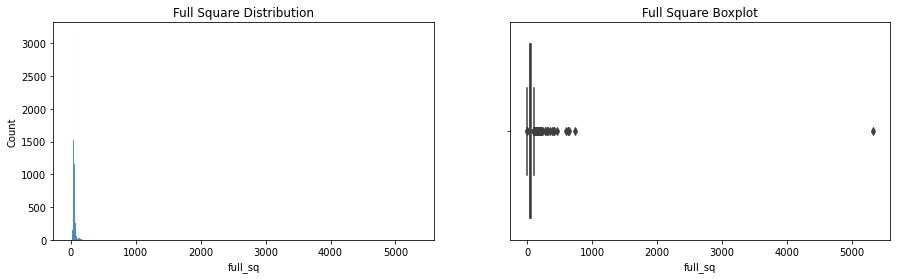

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=sber_data, x='full_sq', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=sber_data, x='full_sq', ax=axes[1]);
boxplot.set_title('Full Square Boxplot');

именно так выглядят типичные графики распределений с выбросами в данных. 

Алгоритм метода:

→ вычислить 25-ый и 75-ый квантили (первый q25 и третий q75 квартили) — для признака, который мы исследуем;

→ вычислить межквартильное расстояние: i=q75-q25 ;

→ вычислить верхнюю и нижнюю границы Тьюки: q25-1.5i , q75+1.5i 

→ найти наблюдения, которые выходят за пределы границ.

In [5]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [6]:
# Применим эту функцию к таблице sber_data и признаку full_sq, а также выведем размерности результатов:

outliers, cleaned = outliers_iqr(sber_data, 'full_sq')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 963
Результирующее число записей: 29508


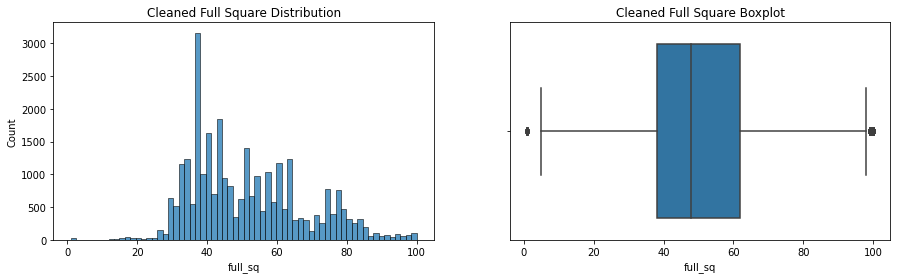

In [7]:
# Давайте построим гистограмму и коробчатую диаграмму на новых данных cleaned_sber_data:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

если присмотреться, то коробчатая диаграмма всё ещё продолжает говорить,
 что в данных есть одиночные выбросы с обеих сторон от границ. 
 К тому же у нас сильно урезался диапазон жилой площади — 
 максимальная площадь составляет около 100 кв. м. 

Причина кроется в том, что после удаления выбросов квартили рассчитываются заново по новым данным, 
и так оказалось, что из-за свойств распределения были снова найдены точки, которые считаются выбросами.

Классический метод межквартильного размаха не учитывает особенностей распределения! 
Он требует, чтобы данные были распределены плюс-минус нормально (гистограмма должна быть похожа на колокол) 
и требует от распределения примерной симметричности (чтобы у гистограммы были одинаковые хвосты в обе стороны).

In [14]:
def outliers_iqr_mod(data, feature,left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [15]:
outliers, cleaned = outliers_iqr_mod(sber_data, 'full_sq',1,6)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 59
Результирующее число записей: 30403


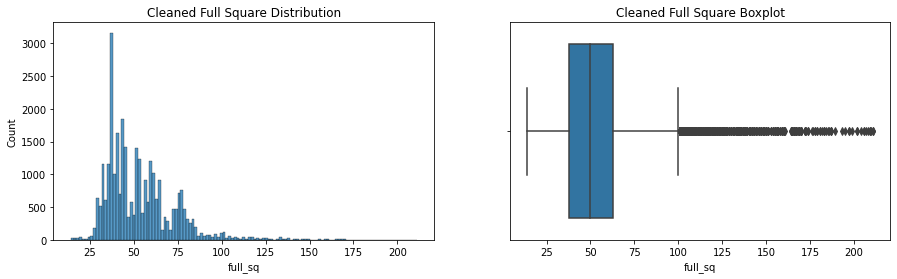

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

## МЕТОД Z-ОТКЛОНЕНИЙ (МЕТОД СИГМ)

Последний метод, который мы рассмотрим, — это метод, основанный на правиле трёх сигм для нормального распределения. 

Правило трёх сигм гласит: 
если распределение данных является нормальным, 
то 99,73 % лежат в интервале от m-3s до m+3s, где   
m(мю) — математическое ожидание (для выборки это среднее значение),
а  s(сигма) — стандартное отклонение. 
Наблюдения, которые лежат за пределами этого интервала, будут считаться выбросами.

что делать, если данные не распределены нормально? 

 Иногда для распределений, похожих на логнормальное, может помочь логарифмирование. 
 Оно может привести исходное распределение к подобию нормального. 
 Причем, основание логарифма может быть любым.

Построим две гистограммы признака расстояния до МКАД (mkad_km): первая — в обычном масштабе, а вторая — в логарифмическом. 

Признак имеет среди своих значений 0. 
Из математики известно, что логарифма от 0 не существует, 
поэтому мы прибавляем к нашему признаку 1, чтобы не логарифмировать нули и не получать предупреждения.

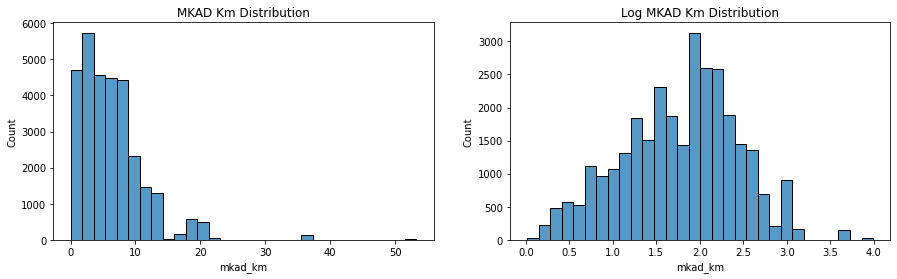

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(sber_data['mkad_km'], bins=30, ax=axes[0])
histplot.set_title('MKAD Km Distribution');

#гистограмма в логарифмическом масштабе
log_mkad_km= np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km , bins=30, ax=axes[1])
histplot.set_title('Log MKAD Km Distribution');

Левое распределение напоминает логнормальное распределение с наличием потенциальных выбросов-«пеньков», 
далеко отстоящих от основной массы наблюдений.

Взяв натуральный логарифм от левого распределения, 
мы получаем правое, которое напоминает слегка перекошенное нормальное.
 Слева от моды (самого высокого столбика) наблюдается чуть больше наблюдений, нежели справа. 
 По-научному это будет звучать так: «распределение имеет левостороннюю асимметрию».

In [19]:
# Примечание: Численный показатель асимметрии можно вычислить с помощью метода:

print(log_mkad_km.skew())
# -0.14263612203024953


-0.14263612203024953


Асимметрия распределения называется правосторонней, если она положительнаz
Асимметрия распределения называется левосторонней, если она отрицательная:

Давайте реализуем алгоритм метода z-отклонения. Описание алгоритма метода:

→ вычислить математическое ожидание (среднее) и стандартное отклонение  признака ;

→ вычислить нижнюю и верхнюю границу интервала как:

→ найти наблюдения, которые выходят за пределы границ.

In [20]:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [21]:
outliers, cleaned = outliers_z_score(sber_data, 'mkad_km', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 33
Результирующее число записей: 30438


In [22]:
print(outliers['sub_area'].unique())

['Poselenie Rogovskoe' 'Poselenie Kievskij']


мы не учли того факта, что наш логарифм распределения всё-таки не идеально нормален и в нём присутствует некоторая асимметрия. 
Возможно, стоит дать некоторое «послабление» на границы интервалов?
 Давайте отдельно построим гистограмму прологарифмированного распределения, 
 а также отобразим на гистограмме вертикальные линии, 
 соответствующие среднему (центру интервала в методе трёх сигм) и границы интервала . 
 Вертикальные линии можно построить с помощью метода axvline(). 
 Для среднего линия будет обычной, а для границ интервала — пунктирной (параметр ls ='--'):

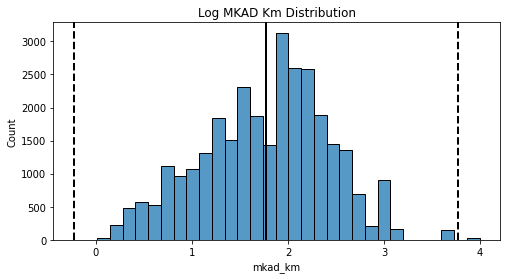

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_mkad_km = np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km, bins=30, ax=ax)
histplot.axvline(log_mkad_km.mean(), color='k', lw=2)
histplot.axvline(log_mkad_km.mean()+ 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.axvline(log_mkad_km.mean()- 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.set_title('Log MKAD Km Distribution');

мы графически построили интервал метода трёх сигм поверх нашего распределения. 
Он показывает, какие наблюдения мы берем в интервал, а какие считаем выбросами. 
Легко заметить, среднее значение (жирная вертикальная линия) находится левее моды, это свойство распределений с левосторонней асимметрией. 
Также видны наблюдения, которые мы не захватили своим интервалом (небольшой пенек правее верхней границы) — 
это и есть наши квартиры из из поселений "Роговское" и "Киевский".
 Очевидно, что если немного (меньше чем на одну сигму) "сдвинуть" верхнюю границу вправо, мы захватим эти наблюдения. 



In [24]:
def outliers_z_score_mod(data, feature, 
                         log_scale=False,
                         left=3,
                         right=3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned



In [29]:
outliers, cleaned = outliers_z_score_mod(sber_data, 
                                         'mkad_km', 
                                         log_scale=True,
                                         left=3,
                                         right=3.5)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 0
Результирующее число записей: 30471


## РЕЗЮМЕ ПО МЕТОДАМ ПОИСКА ВЫБРОСОВ

__Метод ручного поиска__ 
тяжело автоматизировать, однако вы сами организовываете проверки, 
следите за процессом отсеивания выбросов 
и руководствуетесь не только статистикой, но и здравым смыслом. 
К тому же из всех представленных только этот метод 
способен выявить логические нестыковки в данных 
(например, общая площадь меньше жилой или число этажей более 77 в районе, где нет таких зданий). 
Обычно этот метод используется в комплексе с другими, 
чтобы удостовериться в том, что найденные данные действительно 
являются выбросами, и произвести логическую очистку, 
на которую неспособны другие методы.

__Методы межквартильного размаха и z-отклонений__ 
довольно просты в реализации и основаны на стройной математической теории, а не на эвристиках. 
Но это их преимущество и недостаток. Оба метода разработаны для данных, распределённых приблизительно нормально. 
Проблема в том, что далеко не всё в мире имеет нормальное распределение.
 Необходимо внимательно «рыться» в данных, совершать дополнительные преобразования, 
 чтобы привести их хотя бы к подобию нормального распределения, либо подбирать границы методов, 
 чтобы учитывать особенности распределений. 
 В противном случае методы начинают считать выбросами всё, 
 что не вписывается в жёсткие границы, 
 и вы рискуете лишиться важных данных! 
 Учитывайте это в своей работе и всегда проверяйте результаты.

## ДРУГИЕ МЕТОДЫ ПОИСКА ВЫБРОСОВ

в машинном обучении есть отдельная активно развивающаяся подобласть, именуемая Outliers (Anomaly) Detection. 
Она включает в себя большое количество методов для поиска аномалий в совершенно различных видах данных: 
от временных рядов до географических данных. 
Специалисты этой области обучают целые модели, которые помогают отыскать выбросы в данных. 

Например, для поиска аномалий часто используется метод кластеризации DBSCAN, 
о котором мы ещё будем говорить в модуле по кластеризации данных далее.
 Метод пытается объединить данные в группы (кластеры), 
 например: квартиры низкого, среднего и премиального класса, 
 опираясь на все признаки. 
 Всё, что не попало ни в какой из кластеров, помечается как выброс (шум).

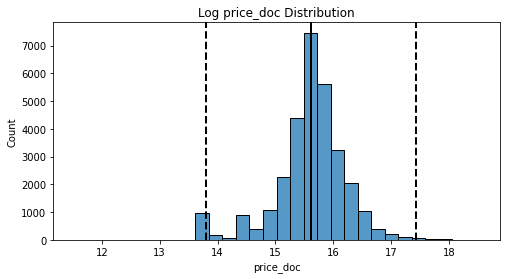

In [30]:
# 6.5
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_price_doc = np.log(sber_data['price_doc'] + 1)
histplot = sns.histplot(log_price_doc, bins=30, ax=ax)
histplot.axvline(log_price_doc.mean(), color='k', lw=2)
histplot.axvline(log_price_doc.mean()+ 3 * log_price_doc.std(), color='k', ls='--', lw=2)
histplot.axvline(log_price_doc.mean()- 3 * log_price_doc.std(), color='k', ls='--', lw=2)
histplot.set_title('Log price_doc Distribution');

In [32]:
outliers, cleaned = outliers_z_score_mod(sber_data, 
                                         'price_doc', 
                                         log_scale=True,
                                         left=3.7,
                                         right=3.7)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 52
Результирующее число записей: 30419


In [38]:
def outliers_iqr_mod_log(data, 
                         feature,
                         log_scale=False,
                         left=1.5, 
                         right=1.5):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [39]:
outliers, cleaned = outliers_iqr_mod_log(sber_data, 
                                           'price_doc', 
                                           log_scale=True,
                                           left=3,
                                           right=3)
print(f'исло выбросов по методу Тьюки log: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 92
Результирующее число записей: 30379


## ДУБЛИКАТЫ

Дублирующаяся информация никогда не приводит ни к чему хорошему. 
В Data Science одинаковые записи не несут полезной информации и искажают реальную статистику. 
Модель несколько раз видит одно и то же наблюдение и начинает подстраиваться под него. 
Если дубликатов много, это может стать большой проблемой при обучении.

Способ обнаружения дубликатов зависит от того, что именно вы считаете дубликатом. 
Например, за дубликаты можно посчитать записи, у которых совпадают все признаки или их часть.

In [40]:
sber_data['id'].nunique() == sber_data.shape[0]

True

Чтобы отследить дубликаты, можно воспользоваться методом duplicated(), который возвращает булеву маску для фильтрации. 
Для записей, у которых совпадают признаки, переданные методу, он возвращает True, для остальных — False.

У метода есть параметр subset — список признаков, по которым производится поиск дубликатов. 
По умолчанию используются все столбцы в DataFrame и ищутся полные дубликаты.

In [42]:
# найдем дубликаты убрав id
dupl_columns = list(sber_data.columns)
dupl_columns.remove('id')

mask = sber_data.duplicated(subset=dupl_columns)
sber_duplicates = sber_data[mask]
print(f'Число найденных дубликатов: {sber_duplicates.shape[0]}')

Число найденных дубликатов: 562


In [43]:
# оздадим новую таблицу sber_dedupped, которая будет версией исходной таблицы, очищенной от полных дубликатов.

sber_dedupped = sber_data.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {sber_dedupped.shape[0]}')

Результирующее число записей: 29909


# НЕИНФОРМАТИВНЫЕ ПРИЗНАКИ

Неинформативными называются признаки, в которых большая часть строк содержит одинаковые значения 
(например, пол клиентов в мужском барбершопе), 
либо наоборот — признак, в котором для большинства записей значения уникальны (например, номер телефона клиента). 

Такие признаки не играют роли при моделировании и лишь засоряют таблицу, увеличивая размерность данных. 
Они усиливают уже знакомое нам проклятие размерности, которое увеличивает время обучения модели и потенциально может снизить ее качество. 

чтобы считать признак неинформативным, прежде всего нужно задать какой-то определённый порог. 
Например, часто используют пороги в 0.95 и 0.99. 
Это означает: признак неинформативен, если в нем 95 % (99 %) одинаковых значений или же 95 % (99 %) данных полностью уникальны.

Разберём алгоритм:

→ Создаём пустой список low_information_cols, куда будем добавлять названия признаков, которые мы посчитаем неинформативными.

→ В цикле пройдёмся по всем именам столбцов в таблице и для каждого будем совершать следующие действия:

* рассчитаем top_freq — наибольшую относительную частоту с помощью метода value_counts() с параметром normalize=True. 
Метод вернёт долю от общих данных, которую занимает каждое уникальное значение в признаке.
* рассчитаем nunique_ratio — отношение числа уникальных значений в столбце к размеру всего столбца. 
Число уникальных значений в столбце получим с помощью метода nunique(), а размер признака — с помощью метода count(). 

* сравним каждое из полученных чисел с пороговым значением (у нас это 0.95) и добавим в список неинформативных признаков, если условие истинно.

In [44]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in sber_data.columns:
    #наибольшая относительная частота в признаке
    top_freq = sber_data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = sber_data[col].nunique() / sber_data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

id: 100.0% уникальных значений
oil_chemistry_raion: 99.03% одинаковых значений
railroad_terminal_raion: 96.27% одинаковых значений
nuclear_reactor_raion: 97.17% одинаковых значений
big_road1_1line: 97.44% одинаковых значений
mosque_count_1000: 98.08% одинаковых значений


In [45]:
# Теперь можно удалить их с помощью метода drop(), 
# передав результирующий список в его аргументы.

information_sber_data = sber_data.drop(low_information_cols, axis=1)
print(f'Результирующее число признаков: {information_sber_data.shape[1]}')

Результирующее число признаков: 55


# ВАЖНОСТЬ ПРИЗНАКОВ

На самом деле информативность признаков определяется не только числом уникальных значений, 
но и их влиянием на целевой признак (тот, который мы хотим предсказать). Это называется важностью признака. 

Признаки, которые обладают низкой важностью, называют __нерелевантными признаками__. 